In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
mpl.rc('figure', figsize=(16,8))
import matplotlib.pyplot as plt
import os
import glob
import re
import pims
from nd2reader import ND2Reader
import tifffile
import trackpy as tp

Get list of files in the directory

In [2]:
#files = np.sort(glob.glob(os.path.join(os.getcwd(), 'proc', '*.tif')))
path = '../data/exp_raw/2023-07-29_12B09/'
files = np.sort(glob.glob(os.path.join(path, 'tile*.tif')))
xyfiles = np.sort(glob.glob(os.path.join(path, 'xy*.dat')))
pattern = re.compile(r'\d+.tif')
files

array(['../data/exp_raw/2023-07-29_12B09/tile_01.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_02.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_03.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_04.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_05.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_06.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_07.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_08.tif',
       '../data/exp_raw/2023-07-29_12B09/tile_09.tif'], dtype='<U44')

## Preliminary analysis

Use one of the files to find optimal parameters for analysis

In [3]:
file = files[8]
fname = pattern.findall(file)[0]
print('Analysing ', fname, '...')

Analysing  09.tif ...


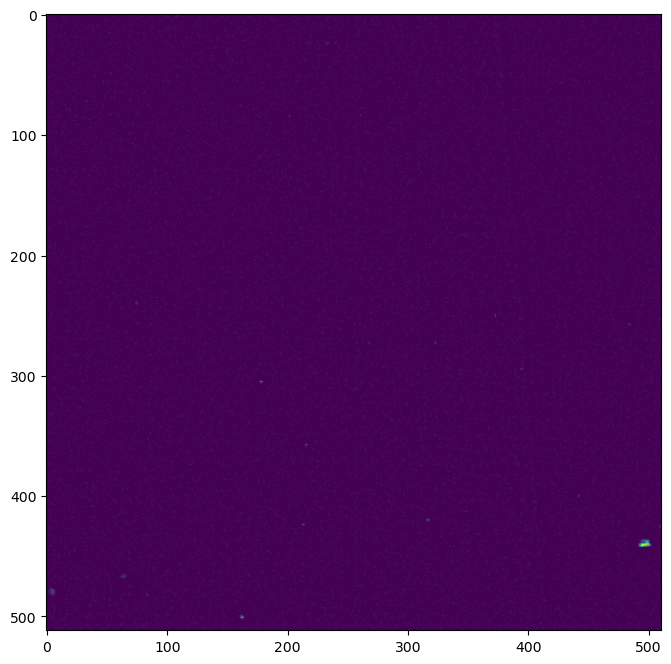

In [4]:
# Read frames
# frames = ND2Reader(file)
frames = tifffile.imread(file)
# Show a sample frame
plt.imshow(frames[0]);

Locate features

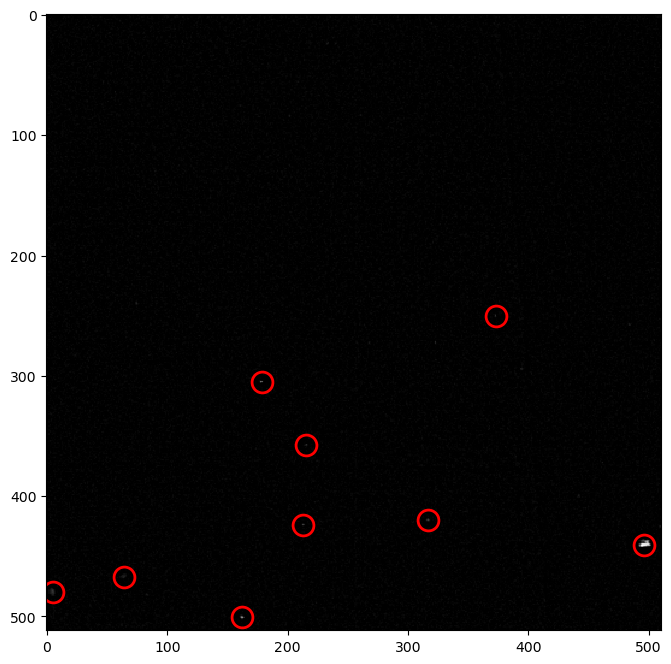

In [5]:
size = 9 # px
minmass = 85
maxsize = 35 # px
f = tp.locate(frames[0], size, minmass=minmass, maxsize=maxsize)
tp.annotate(f, frames[0]);

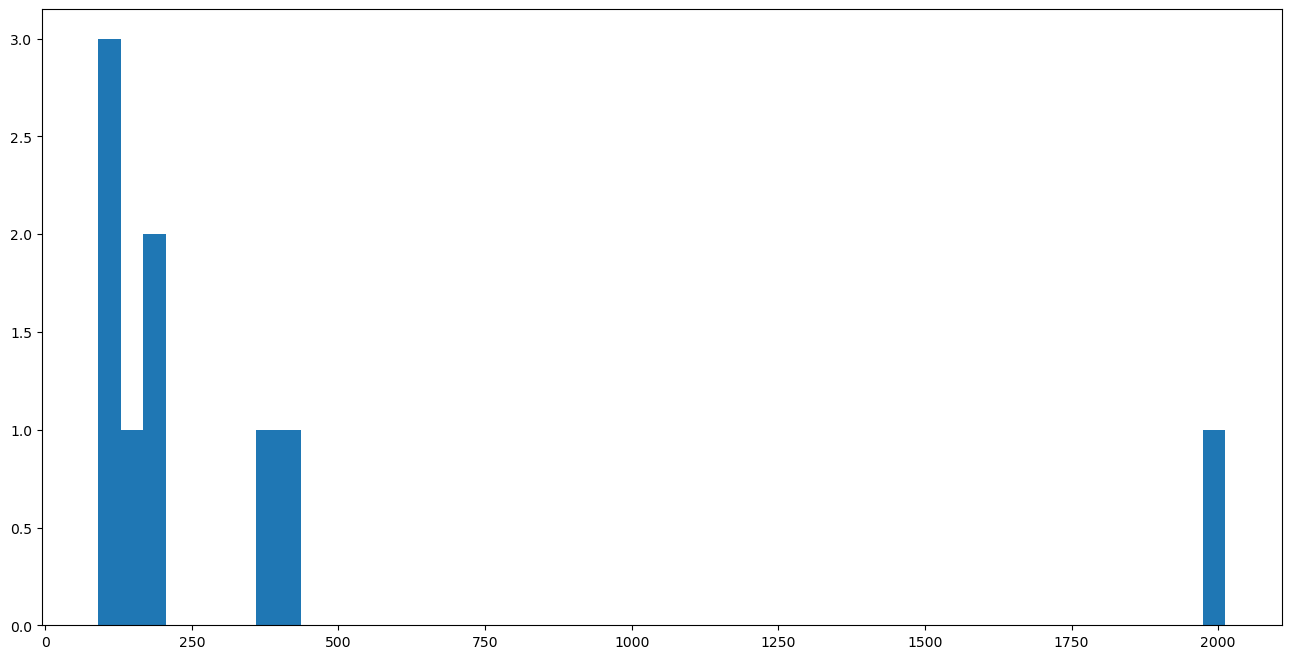

In [6]:
plt.hist(f['mass'], bins=50);

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

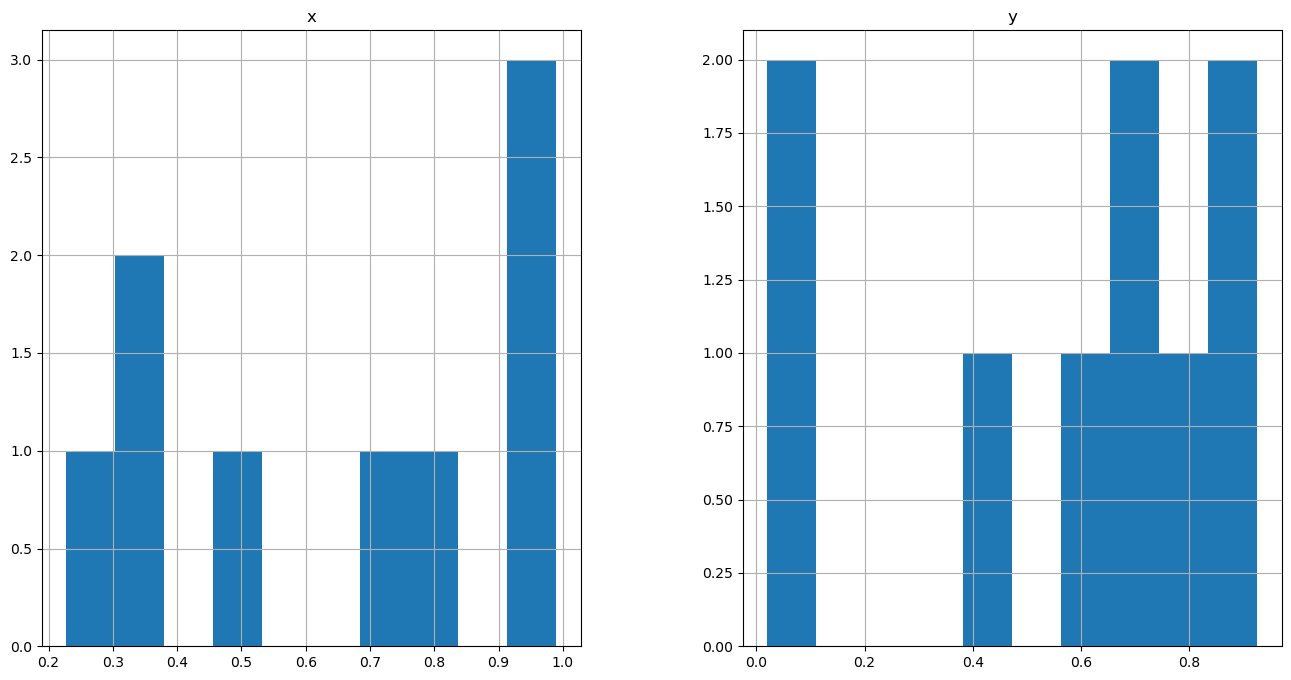

In [7]:
tp.subpx_bias(f)

## Tracking

In [15]:
max_displacement = 80 # px
memory = 3 # frames
f = tp.batch(frames, size, minmass=minmass, maxsize=maxsize)
t = tp.link(f, max_displacement, memory=memory)

Frame 894: 10 trajectories present.


In [16]:
min_duration = 25 # frames
tf = tp.filter_stubs(t, min_duration)
print('Raw:', t['particle'].nunique(), 'trajectories')
print('Filtered:', tf['particle'].nunique(), 'trajectories')

Raw: 373 trajectories
Filtered: 35 trajectories


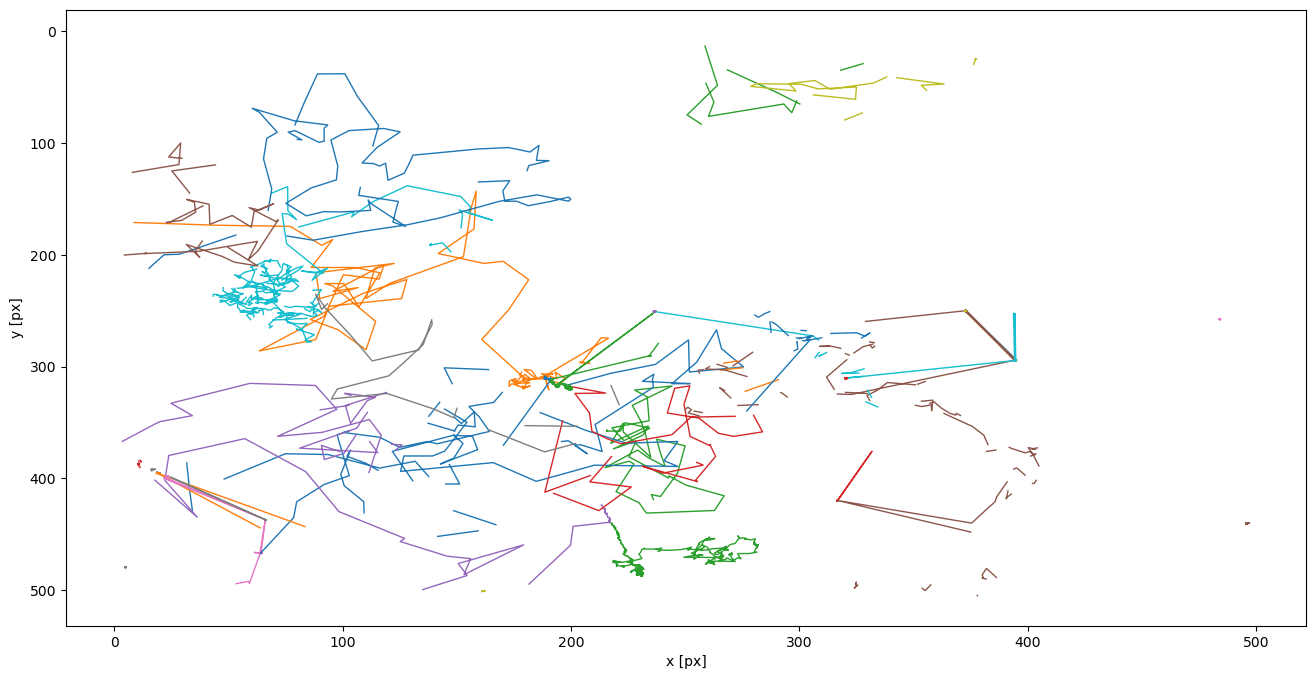

In [14]:
tp.plot_traj(tf);

In [11]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,250.020202,372.989899,90.310039,1.543968,0.173219,11.402783,164.0,0.106674,0
1,305.087838,178.342342,202.513422,1.351509,0.241967,29.647235,310.0,0.052983,0
2,357.578704,215.708333,98.520043,1.449776,0.158151,12.315005,187.0,0.091989,0
3,419.901639,316.921311,139.113950,1.357432,0.219880,19.612786,252.0,0.066225,0
4,423.925743,213.227723,92.134485,1.272325,0.223727,14.595562,163.0,0.107420,0
...,...,...,...,...,...,...,...,...,...
10024,440.437394,495.532149,558.831591,2.078209,0.382268,41.368667,1288.0,0.011488,894
10025,467.016908,63.997585,97.866446,1.630032,0.132711,8.982911,199.0,0.085616,894
10026,472.172594,263.108787,225.991117,1.275370,0.183812,37.113604,345.0,0.045904,894
10027,479.322076,4.860791,286.980352,1.965518,0.211885,19.856960,565.0,0.027019,894


## Identify blobs and merge tiles

In [12]:
d = [f for i in range(len(files))] # dummy list of dataframes
for i in range(len(files)):
    x1, x2, y1, y2 = np.fromfile(xyfiles[i], sep='\n')
    frames = tifffile.imread(files[i])
    ny, nx = frames[0].shape
    size = 9 # px
    minmass = 85
    maxsize = 35 # px
    f = tp.batch(frames[0:350], size, minmass=minmass, maxsize=maxsize)
    itp_x = lambda x: x1 + x/nx * x2
    itp_y = lambda y: y1 + y/ny * y2
    # inverted dimensions in trackpy
    f['y'] = f['y'].apply(itp_x)
    f['x'] = f['x'].apply(itp_y)
    d[i] = f

df = pd.concat(d)

Frame 349: 10 features


## Track over entire domain

In [22]:
max_displacement = 80*6.5 # μm
memory = 3 # frames
t = tp.link(df, max_displacement, memory=memory)
min_duration = 50 # frames
tf = tp.filter_stubs(t, min_duration)
print('Raw:', t['particle'].nunique(), 'trajectories')
print('Filtered:', tf['particle'].nunique(), 'trajectories')

Frame 349: 88 trajectories present.
Raw: 1118 trajectories
Filtered: 136 trajectories


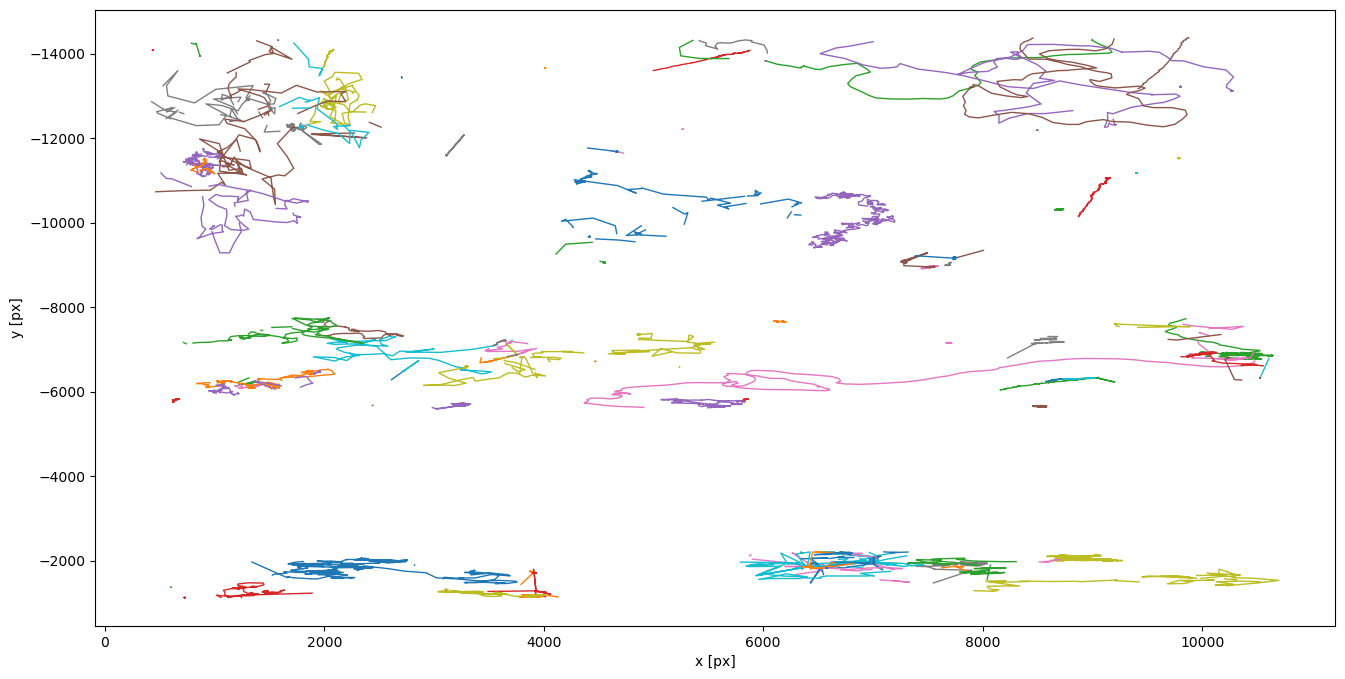

In [49]:
tp.plot_traj(tf[tf['x']>0]);